In [2]:
import sys
import os
from scipy.io import wavfile
import numpy as np
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [7]:
os.environ["DATA_DIR"] = "/tmp/data_dir"
data_folder = os.environ["DATA_DIR"]

In [4]:
# http://stackoverflow.com/questions/2459295/invertible-stft-and-istft-in-python

In [8]:
fs, data = wavfile.read(data_folder + os.path.sep + "data.wav")
print data.dtype
data = np.asarray(data, dtype="float32")
min_, max_, mean_ = np.min(data), np.max(data), np.mean(data)

int16


In [10]:
st = stft(data, fs, 1, 1)
print st.shape

(10889, 16000)


In [11]:
len(data) / 16000.0

10889.3460625

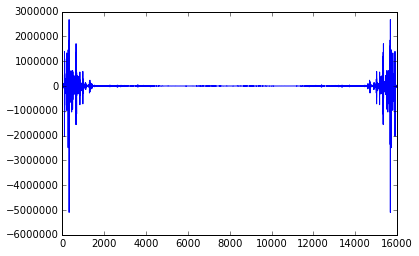

In [17]:
plt.plot(st[4534])

In [44]:
scipy.fft(data[0:16000]).real

array([ 2696.        ,  3273.00149098,  3802.42697177, ..., -2050.59698345,
        3802.42697177,  3273.00149098])

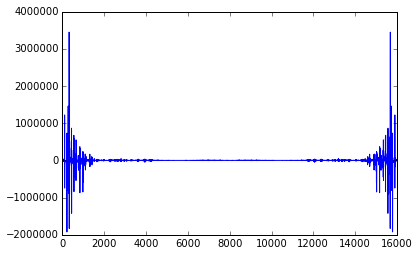

In [45]:
plt.plot( scipy.fft(data[0:16000]).real )

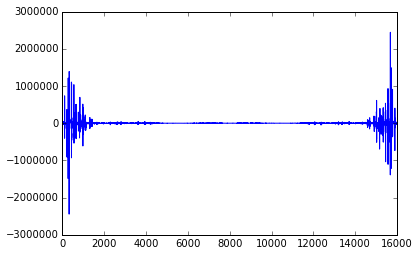

In [46]:
plt.plot( scipy.fft(data[0:16000]).imag )

Examining SciPy FFT examples...

In [30]:
scipy.real( scipy.ifft( scipy.fft(data[0:16000]) ) )

array([ -2.03726813e-13,   2.91038305e-14,   2.32830644e-13, ...,
         8.98000000e+02,   5.74000000e+02,   2.31000000e+02])

In [32]:
?scipy.fft

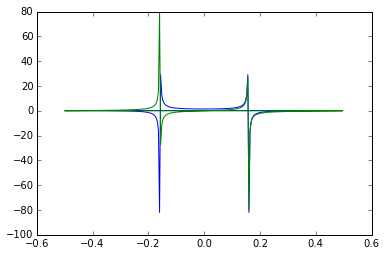

In [41]:
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)

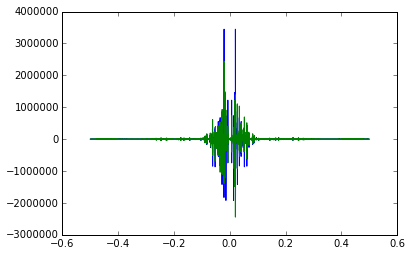

In [53]:
t = data[0:16000]
sp = np.fft.fft(t)
freq = np.fft.fftfreq(t.shape[-1])
# x axis is frequency and y axis is amplitude (real/imag?)
plt.plot(freq, sp.real, freq, sp.imag)

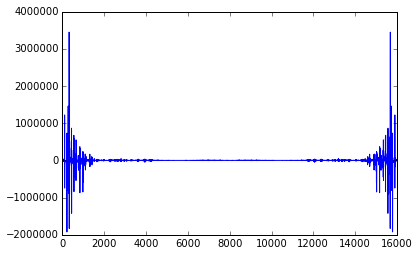

In [55]:
plt.plot(sp.real)

In [58]:
sp.real.shape, sp.imag.shape

((16000,), (16000,))

In [61]:
np.min(sp.real), np.max(sp.real), np.mean(sp.real)

(-1921829.6242346906, 3447696.8843622585, -1.0913936421275138e-13)

In [62]:
np.min(sp.imag), np.max(sp.imag), np.mean(sp.real)

(-2444056.3499231571, 2444056.3499231623, -1.0913936421275138e-13)

In [196]:
t

array([   0.,    0.,    0., ...,  898.,  574.,  231.], dtype=float32)

In [205]:
scipy.real( scipy.ifft(sp.real + 1j*sp.imag) )

array([ -2.03726813e-13,   2.91038305e-14,   2.32830644e-13, ...,
         8.98000000e+02,   5.74000000e+02,   2.31000000e+02])

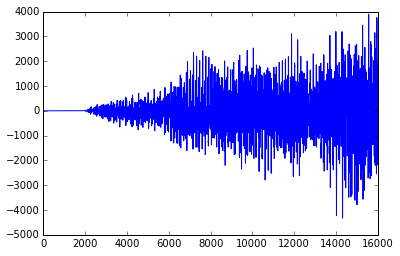

In [206]:
plt.plot( scipy.real( scipy.ifft(sp.real + 1j*sp.imag) ) )

------

In [151]:
def generate_x(data, fs, offset=0.25):
    """
    fs = what's my frame size?
    16000 = a full second
    8000 = a half second
    (don't confuse this with sampling rate, they
    could be the same, or different...)
    """
    step_size = int(offset*fs)
    arr = []
    b = 0
    while True:
        #print step_size*b, (step_size*b)+fs
        chunk = data[step_size*b : (step_size*b)+fs]
        if len(chunk) != fs:
            break
        arr.append(chunk)
        b += 1
    return arr

In [165]:
# give me frames consisting of 8000 samples,
# and offset by 0.25*8000=2000, e.g. give me
# x[0:8000], x[2000:10000], x[4000:12000], etc.
frame_size = 8000
generated_x = generate_x(data[0:16000*100], frame_size, 0.25)

In [153]:
generated_x[0].shape

(8000,)

How long is this sequence really, if the offset = 8?

In [108]:
tt = np.asarray( generate_x([x for x in range(0, 20)], 8) )
tt

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [10, 11, 12, 13, 14, 15, 16, 17],
       [12, 13, 14, 15, 16, 17, 18, 19]])

In [115]:
# (fs + (seq_length-1)*0.25*fs) / fs
(8.0 + (7-1)*2) / 8.0

2.5

----

In [154]:
X_real = []
for seq in generated_x:
    X_real.append( scipy.fft(seq).real )
X_imag = []
for seq in generated_x:
    X_imag.append( scipy.fft(seq).imag )
X_real = np.asarray(X_real)
X_imag = np.asarray(X_imag)
print X_real.shape, X_imag.shape

X_real_min, X_real_max = np.min(X_real), np.max(X_real)
X_imag_min, X_imag_max = np.min(X_imag), np.max(X_imag)

print X_real_min, X_real_max
print X_imag_min, X_imag_max 

(797, 8000) (797, 8000)
-10677328.8154 9364006.34764
-10492150.779 10492150.779


Ok, scale the values and then concatenate them into a final vector.

In [155]:
X_real = (X_real - X_real_min) / (X_real_max - X_real_min)
X_imag = (X_imag - X_imag_min) / (X_imag_max - X_imag_min)

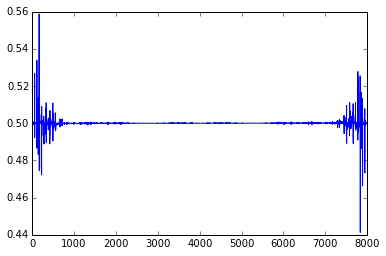

In [156]:
plt.plot(X_imag[1])

In [163]:
seq_length = 5 # we want 10 seconds for our sequence length

In [186]:
X_final = []
# ok, suppose frameSize = 8000, and we want
# seq_length = 5 seconds of audio. then, we
# solve the following eqn for x:
# frameSize*x = 16000*seq_length
how_many_do_i_need = int( (16000.0*seq_length) / (frame_size) )
b = 0
X_final = []
while True:
    batch = np.hstack( (X_real[b : b+how_many_do_i_need], X_imag[b : b+how_many_do_i_need]) )
    if batch.shape[0] != how_many_do_i_need:
        break
    X_final.append(batch)
    b += 1

In [187]:
np.asarray(X_final).shape

(788, 10, 16000)

In [174]:
(16000.0*5) / (8000)

10.0